In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

sns.set_style('whitegrid')

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Use graphviz to make a chart of the regression tree decision points:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus


In [3]:
df = pd.read_csv('/Users/jyots/Desktop/DS_Projects/airbnb_DataSets/Berlin_dfm.csv',
                   encoding='utf8')

In [4]:
df.head(2)

,Unnamed: 0,bathrooms,bedrooms,bhk,dist_arprt,host_count,metrostn_count,minstay,neighborhood,overall_satisfaction,price,rest_count,review_count,reviews,room_type
0,0,8.0,10.0,10.0,0.057015,1206,30,1.0,Charlottenburg-Wilmersdorf,5.0,80.0,9,11850,1,Entire home/apt
1,1,1.0,2.0,2.0,0.057015,1206,30,3.0,Charlottenburg-Wilmersdorf,4.0,104.0,9,11850,1,Entire home/apt


In [5]:
df.drop('Unnamed: 0', inplace=True, axis=1)

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet, LassoCV, Lasso

import patsy

In [7]:
X = df[[x for x in df.columns if x not in ['bhk','price']]]
y = df.price.values
target = np.log(y)



In [8]:
formula = "target ~ "+' + '.join(X)+' -1'
formula

u'target ~ bathrooms + bedrooms + dist_arprt + host_count + metrostn_count + minstay + neighborhood + overall_satisfaction + rest_count + review_count + reviews + room_type -1'

In [9]:
y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
y = y.values.ravel()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [11]:
X_train.shape, X_test.shape

((10357, 24), (4439, 24))

In [12]:
reg_scores = cross_val_score(LinearRegression(), X_train, y_train, cv= 10)
print reg_scores, np.mean(reg_scores)

[  4.41696564e-01   5.04615971e-01   4.50500633e-01   5.03947113e-01
   4.64556860e-01  -9.78745408e+04   4.66516512e-01   4.84401054e-01
   4.57850163e-01   4.52461365e-01] -9787.03142055


In [13]:
linreg = LinearRegression().fit(X_train, y_train)

In [14]:
from sklearn.tree import DecisionTreeRegressor


In [15]:
predictions = cross_val_predict(linreg, X_test, y_test, cv = 10) 
accuracy = metrics.r2_score(y_test, predictions)
print accuracy


0.479361818315


In [16]:
residuals = y_test - predictions
residuals

array([ 0.3971973 , -0.42317827,  0.00298539, ..., -0.77184816,
       -0.54108199, -0.01979697])

In [17]:
np.mean(predictions)


4.0446200476803149

In [18]:
#linmod.coef_

In [19]:
print np.mean(y_train), np.mean(y_test)

4.0408083405 4.04473104169


In [20]:
Xn = StandardScaler().fit_transform(X)

In [21]:
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size = 0.3)

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [23]:
rf = RandomForestRegressor()

rf_params = {
    'n_estimators':[500],
    'max_depth':[5,8,15,25,30,None],
    'min_samples_split':[2,4,8,16,32,64,128],
    'max_features':[None, 'sqrt', 'log2']
}

rf_gs = GridSearchCV(rf, rf_params, cv= 10, verbose=1, n_jobs=-1)
rf_gs.fit(Xn_train, y_train)

Fitting 10 folds for each of 126 candidates, totalling 1260 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed: 28.8min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [500], 'min_samples_split': [2, 4, 8, 16, 32, 64, 128], 'max_depth': [5, 8, 15, 25, 30, None], 'max_features': [None, 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [24]:
print rf_gs.best_params_
rf_best = rf_gs.best_estimator_

rf_scores = cross_val_score(rf_best, Xn_train, y_train, cv=10)
print rf_scores
print np.mean(rf_scores), np.std(rf_scores)

{'max_features': None, 'min_samples_split': 128, 'n_estimators': 500, 'max_depth': 30}
[ 0.52867015  0.50553406  0.54578488  0.51088124  0.50833205  0.44007487
  0.45110991  0.56797742  0.45016408  0.51817223]
0.502670089093 0.0405973247378


In [25]:
y_pred = rf_best.fit(Xn_train,y_train).predict(Xn_test)
r2_score = metrics.r2_score(y_test, y_pred)
print("r^2 on test data : %f" % r2_score)


r^2 on test data : 0.526232


In [26]:
#rf_best.feature_importances_

In [27]:
feature_imp = {}
for i, value in enumerate(rf_best.feature_importances_):
    feature_imp[i] = value

feature_imp = pd.DataFrame(feature_imp.items(), columns=['item_no','imp'])
feature_imp.head(2)

,item_no,imp
0,0,0.000806
1,1,0.000432


In [28]:
feature_name = {}
for i, value in enumerate(X_train.columns):
    feature_name[i] = value

feature_name = pd.DataFrame(feature_name.items(), columns=['item_no','name'])
feature_name.head(2)

,item_no,name
0,0,neighborhood[Charlottenburg-Wilmersdorf]
1,1,neighborhood[Friedrichshain-Kreuzberg]


In [29]:
feature_val = feature_name.merge(feature_imp, on='item_no')
feature_val.sort_values('imp',inplace=True,ascending=False,axis=0)

In [30]:
feature_val = feature_val.reset_index(drop=True)

In [31]:
feature_val.head(25)

,item_no,name,imp
0,12,room_type[T.Private room],0.581978
1,15,bedrooms,0.188775
2,19,minstay,0.057766
3,14,bathrooms,0.047404
4,13,room_type[T.Shared room],0.040702
5,16,dist_arprt,0.020781
6,23,reviews,0.020569
7,20,overall_satisfaction,0.012074
8,22,review_count,0.007557
9,17,host_count,0.006138


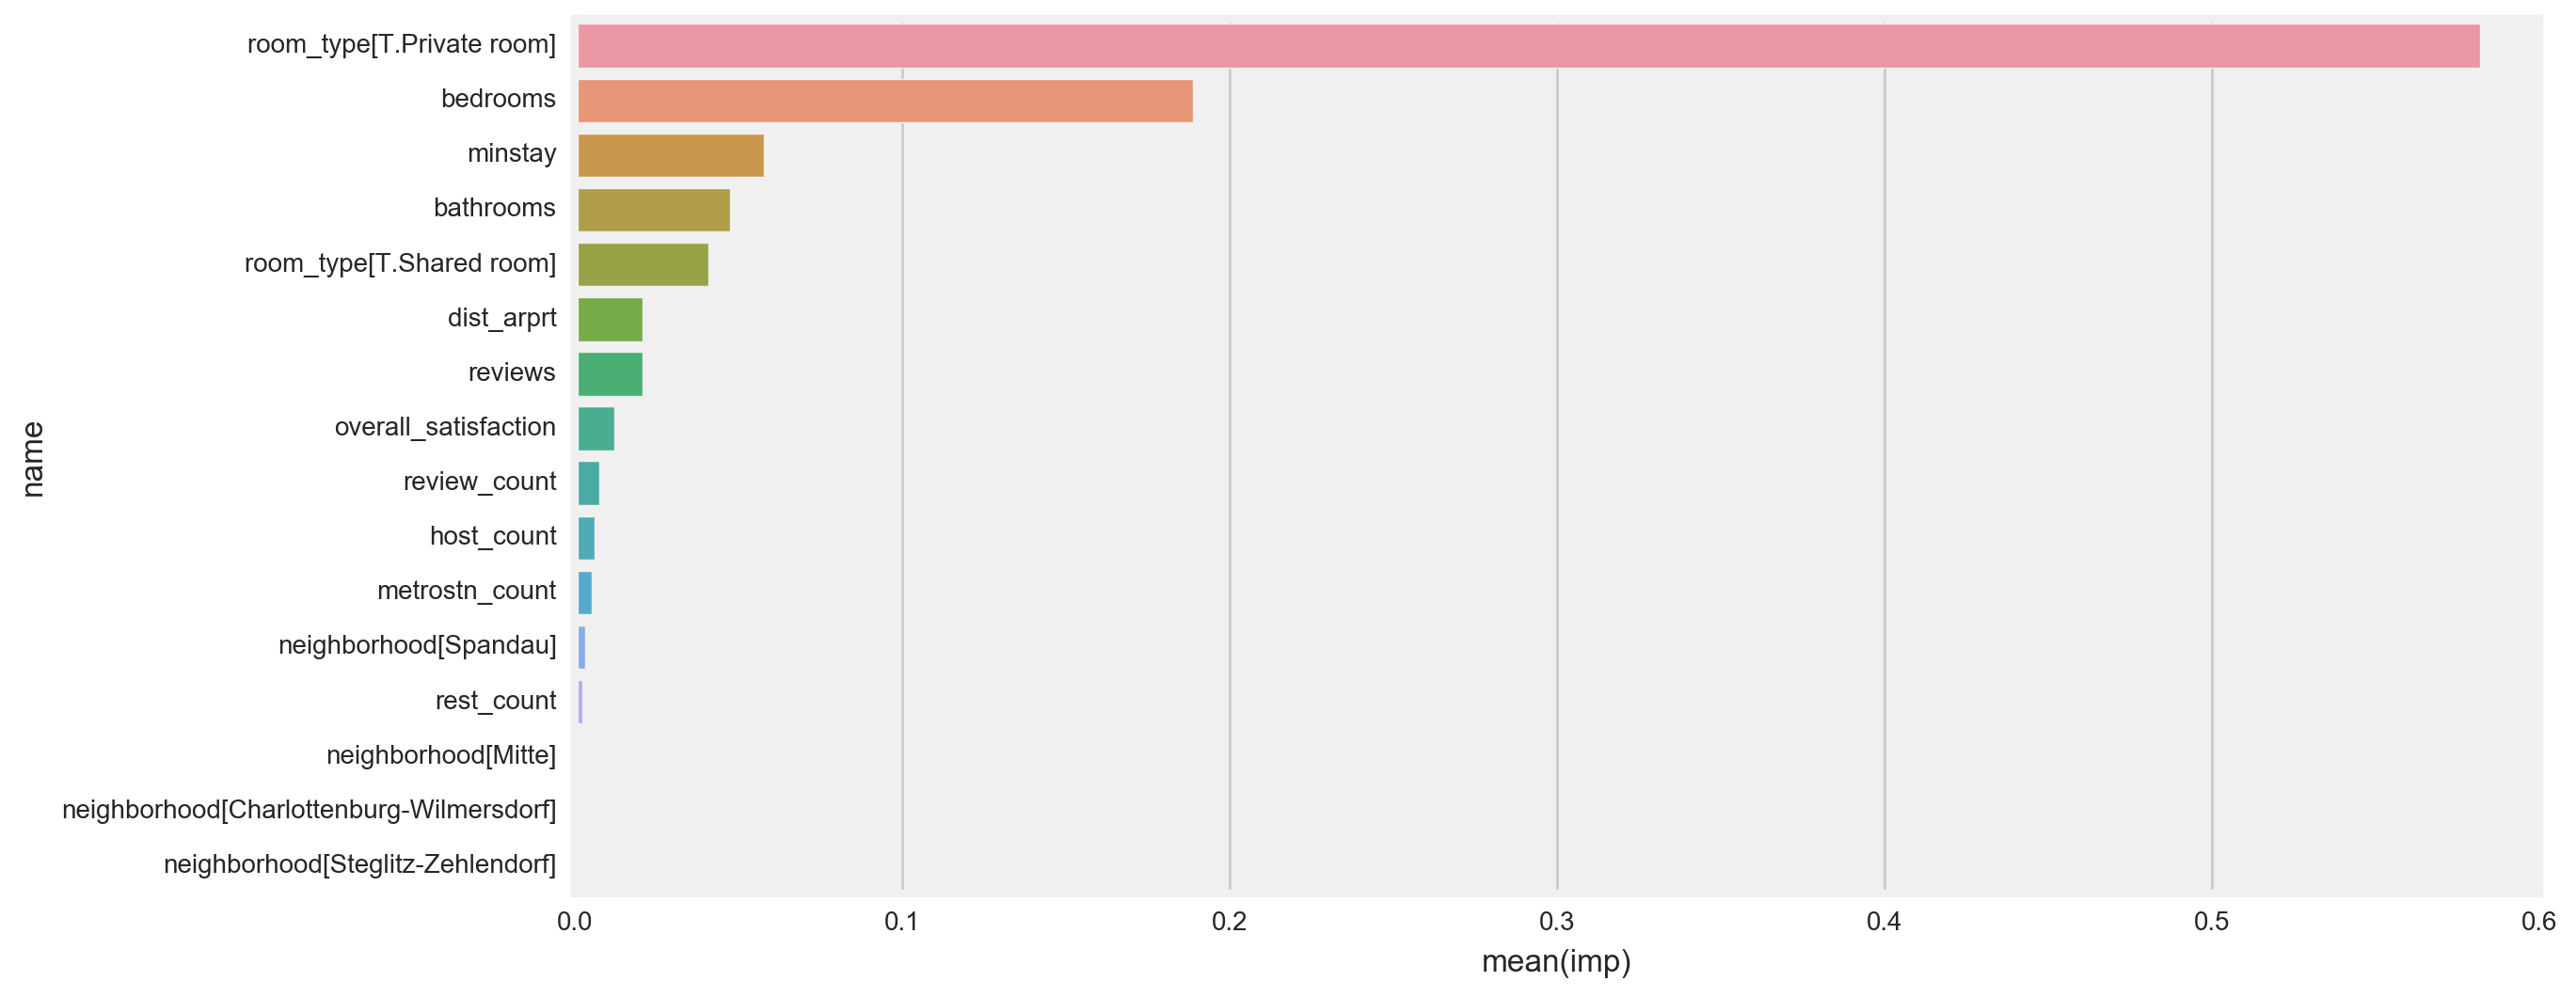

In [32]:
fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(y = feature_val.loc[0:15,:].name, x = feature_val.loc[0:15,:].imp, data=feature_val.loc[0:15,:],orient=""
           )
plt.show()